In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import ShuffleSplit,GridSearchCV,KFold
from sklearn.feature_selection import SelectFromModel


import eli5
from eli5.sklearn import PermutationImportance
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import get_x_y

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")

#### Nous commencons par extraire les donnée l'extraction des donnés cliniques et radiomics en les concatenant dans un meme tableau afin de faire une analyse exploratoire on fait une fonction (extractdata()) pour rendre l'extraction plus facile pour de nouveau données:

## Extracting DATA:

In [2]:
def extractdata(phase='training'):
    
    # récupérer les fichier csv d'entrainement
    clinics=pd.read_csv("X_train\\features\\clinical_data.csv")
    radiomics=pd.read_csv("X_train\\features\\radiomics.csv", header=1)
    if phase == 'testing':
        # récupérer les fichier csv de test
        clinics=pd.read_csv("X_test\\features\\clinical_data.csv")
        radiomics=pd.read_csv("X_test\\features\\radiomics.csv", header=1)
        
    # renomer la colone 0
    radiomics.rename(columns = {'Unnamed: 0':'PatientID'}, inplace = True)
    # supprimer la premiere ligne qui contient que des valeur manquantes
    radiomics=radiomics.drop([0])
    #transformer l'indice à valeur numérique
    radiomics['PatientID']=pd.to_numeric(radiomics['PatientID'])
    # créer le dataset en concatenant les clinic et radiomic
    dataSet=clinics
    dataSet=dataSet.merge(radiomics,on=['PatientID','PatientID'],sort=True)
    # on pose la colonne PantientID comme colonne
    dataSet=dataSet.set_index('PatientID')
        
    return dataSet    

#extraire les données
train_data=extractdata(phase='training')
train_data.head()


,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
2,adenocarcinoma,0,0,l1,3,59.4223,0.024239,0.208753,100.682670,1.685735,...,4.681262,20051.589877,54352.774029,0.608142,0.000918,1342.009256,0.000710,938.104181,0.003537,6567.332842
3,squamous cell carcinoma,0,3,l1,1,77.0986,0.014520,0.074913,178.117938,2.372178,...,1.194862,121.860389,3683.000792,0.943351,0.004979,731.875365,0.004741,695.615307,0.006145,901.956835
4,squamous cell carcinoma,0,0,l1,3,84.5722,0.022972,0.187502,133.895482,1.747154,...,2.776563,3687.540945,53820.687146,0.740312,0.001657,1431.057216,0.001459,1208.546317,0.003430,3740.268350
5,nos,0,0,l1,2,71.8439,0.030597,0.332627,39.319207,1.443269,...,7.285089,1006.359656,1565.874316,0.501632,0.001258,1328.848441,0.000986,816.256111,0.005828,10016.147961
7,squamous cell carcinoma,0,0,l1,4,60.7283,0.024970,0.221540,97.989795,1.652657,...,4.868237,17465.053523,56507.954765,0.605997,0.001264,1264.678549,0.001025,879.772376,0.004216,6675.271359


#### reagardant la répartition de type des données on voit que la plus plupart des données sont de type numérique 
#### et on a des variables de type object qui nécéssitent un encodage :

(300, 59)


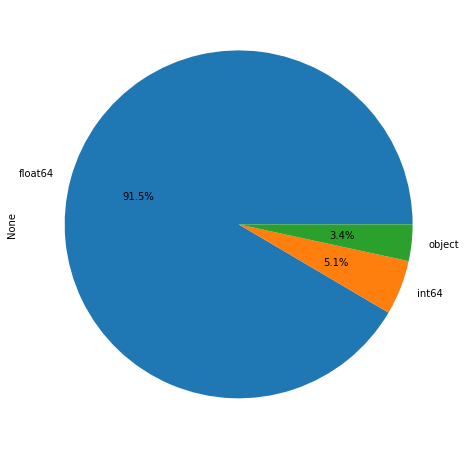

In [3]:
train_data=extractdata()
print(train_data.shape)
#print(data.head(4))

#print('Float:', list(data.select_dtypes('float').columns),'\n')
#print('Integer:', list(data.select_dtypes('int64').columns),'\n')
#print('Object:', list(data.select_dtypes('object').columns),'\n')

plt.figure(figsize=(8,8))
train_data.dtypes.value_counts().plot.pie(autopct='%1.1f%%')


#### regardant la répartiton de données manquante dans le dataset: la colonne 'Histology' en contient 20 et la variable age en contient 16

In [1644]:
#valeur manquantes:
print(f'{"":-<25}')
print('Nb valeurs manquantes:')
print(f'{"":-<25}')
print(train_data.isnull().sum().sort_values(ascending=False).nlargest(4))

-------------------------
Nb valeurs manquantes:
-------------------------
Histology                         20
age                               16
original_firstorder_Energy         0
original_firstorder_Uniformity     0
dtype: int64


#### age: contient 16 valeur manquantes on remplace par médiane ou moyenne et on regarde la densité donc comparent la distribution des ages brut et celles avec une imputation par median et moyenne:
#### Histology : regardant la distribution de la variable Histology  cette variable nécesitent d'abord une correction comme on a des modalité qui représentent la méme modalité (ecrit des fois en majiscule des fois non) et on regroupe la modalité "non specified et nan

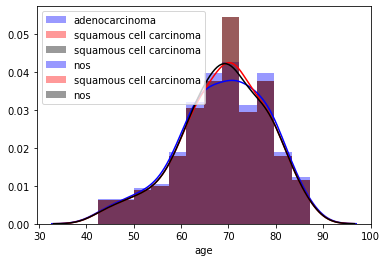

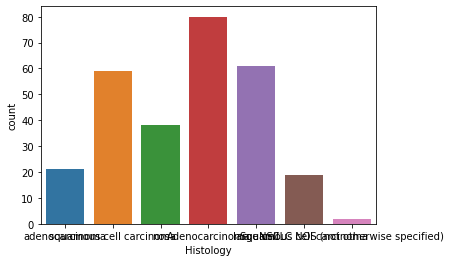

In [1646]:
#visualisons les variables contenant les valeur manquantes

plt.figure(0)
sns.distplot(train_data.age,label='real',color='blue')
sns.distplot(train_data['age'].fillna(train_data['age'].median()),label='median',color='red')
sns.distplot(train_data['age'].fillna(train_data['age'].mean()),label='mean',color='black')
plt.legend(train_data.Histology)

# comme une premier
plt.figure(1)
sns.countplot(train_data.Histology)



#### On peut remplacer age par median (comme il ya pas beaucoup de différence entre la densité donnée par moyenne et médiane) et histology par la modalité la plus fréquente.
#### visualisant la variable à prédire Survival Time: 
##### 1) densité de Survival time: a une distrubition skiwed vers la gauche la plupart des individus ont un temp de survie inférieure à 1000 jours.
##### 2) survie en fonction de l'age: pas de remarque particulier faut pousser l'analyse encore loin mais on peut dire les individus ayant un age >60 la plupart d'eux en un temp de survie inférieure à 500.
##### 3)survivalTime et Sourcedataset: On peut dire que les individus appartenant à la dataset l1 ont un temps de survie petit par rapport à ceux qui appartiennent l2 et on plus l1 contient des individus outliers.
##### 4) survivalTime et Nstage: on voit que plus on avance dans les stage du cancer plus le temps de survie diminue.


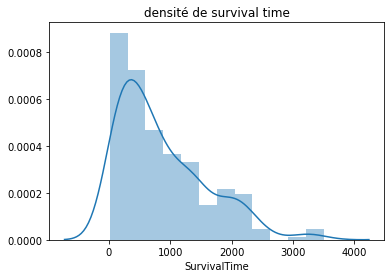

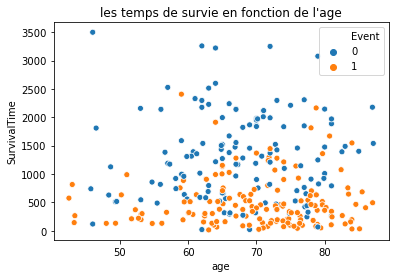

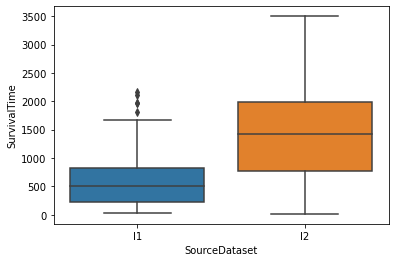

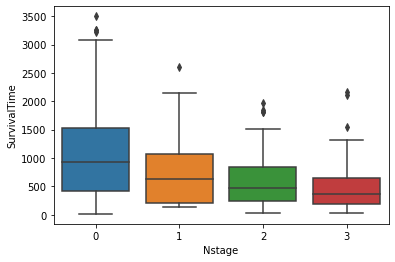

In [13]:
#visualisant la variable à prédire Survival Time:
#1:dansité de Survival time
plt.figure(0)
sns.distplot(y_train.SurvivalTime)
plt.title("densité de survival time")

#survie en fonction de l'age
plt.figure(1)
sns.scatterplot(train_data.age,y_train.SurvivalTime,hue=y_train.Event)
plt.title("les temps de survie en fonction de l'age")

# survivalTime et Sourcedataset
plt.figure(2)
sns.boxplot(x="SourceDataset", y="SurvivalTime", data=pd.concat([train_data,y_train],axis=1))

#survivalTime et Nstage
plt.figure(3)
sns.boxplot(x="Nstage", y="SurvivalTime", data=pd.concat([train_data,y_train],axis=1))

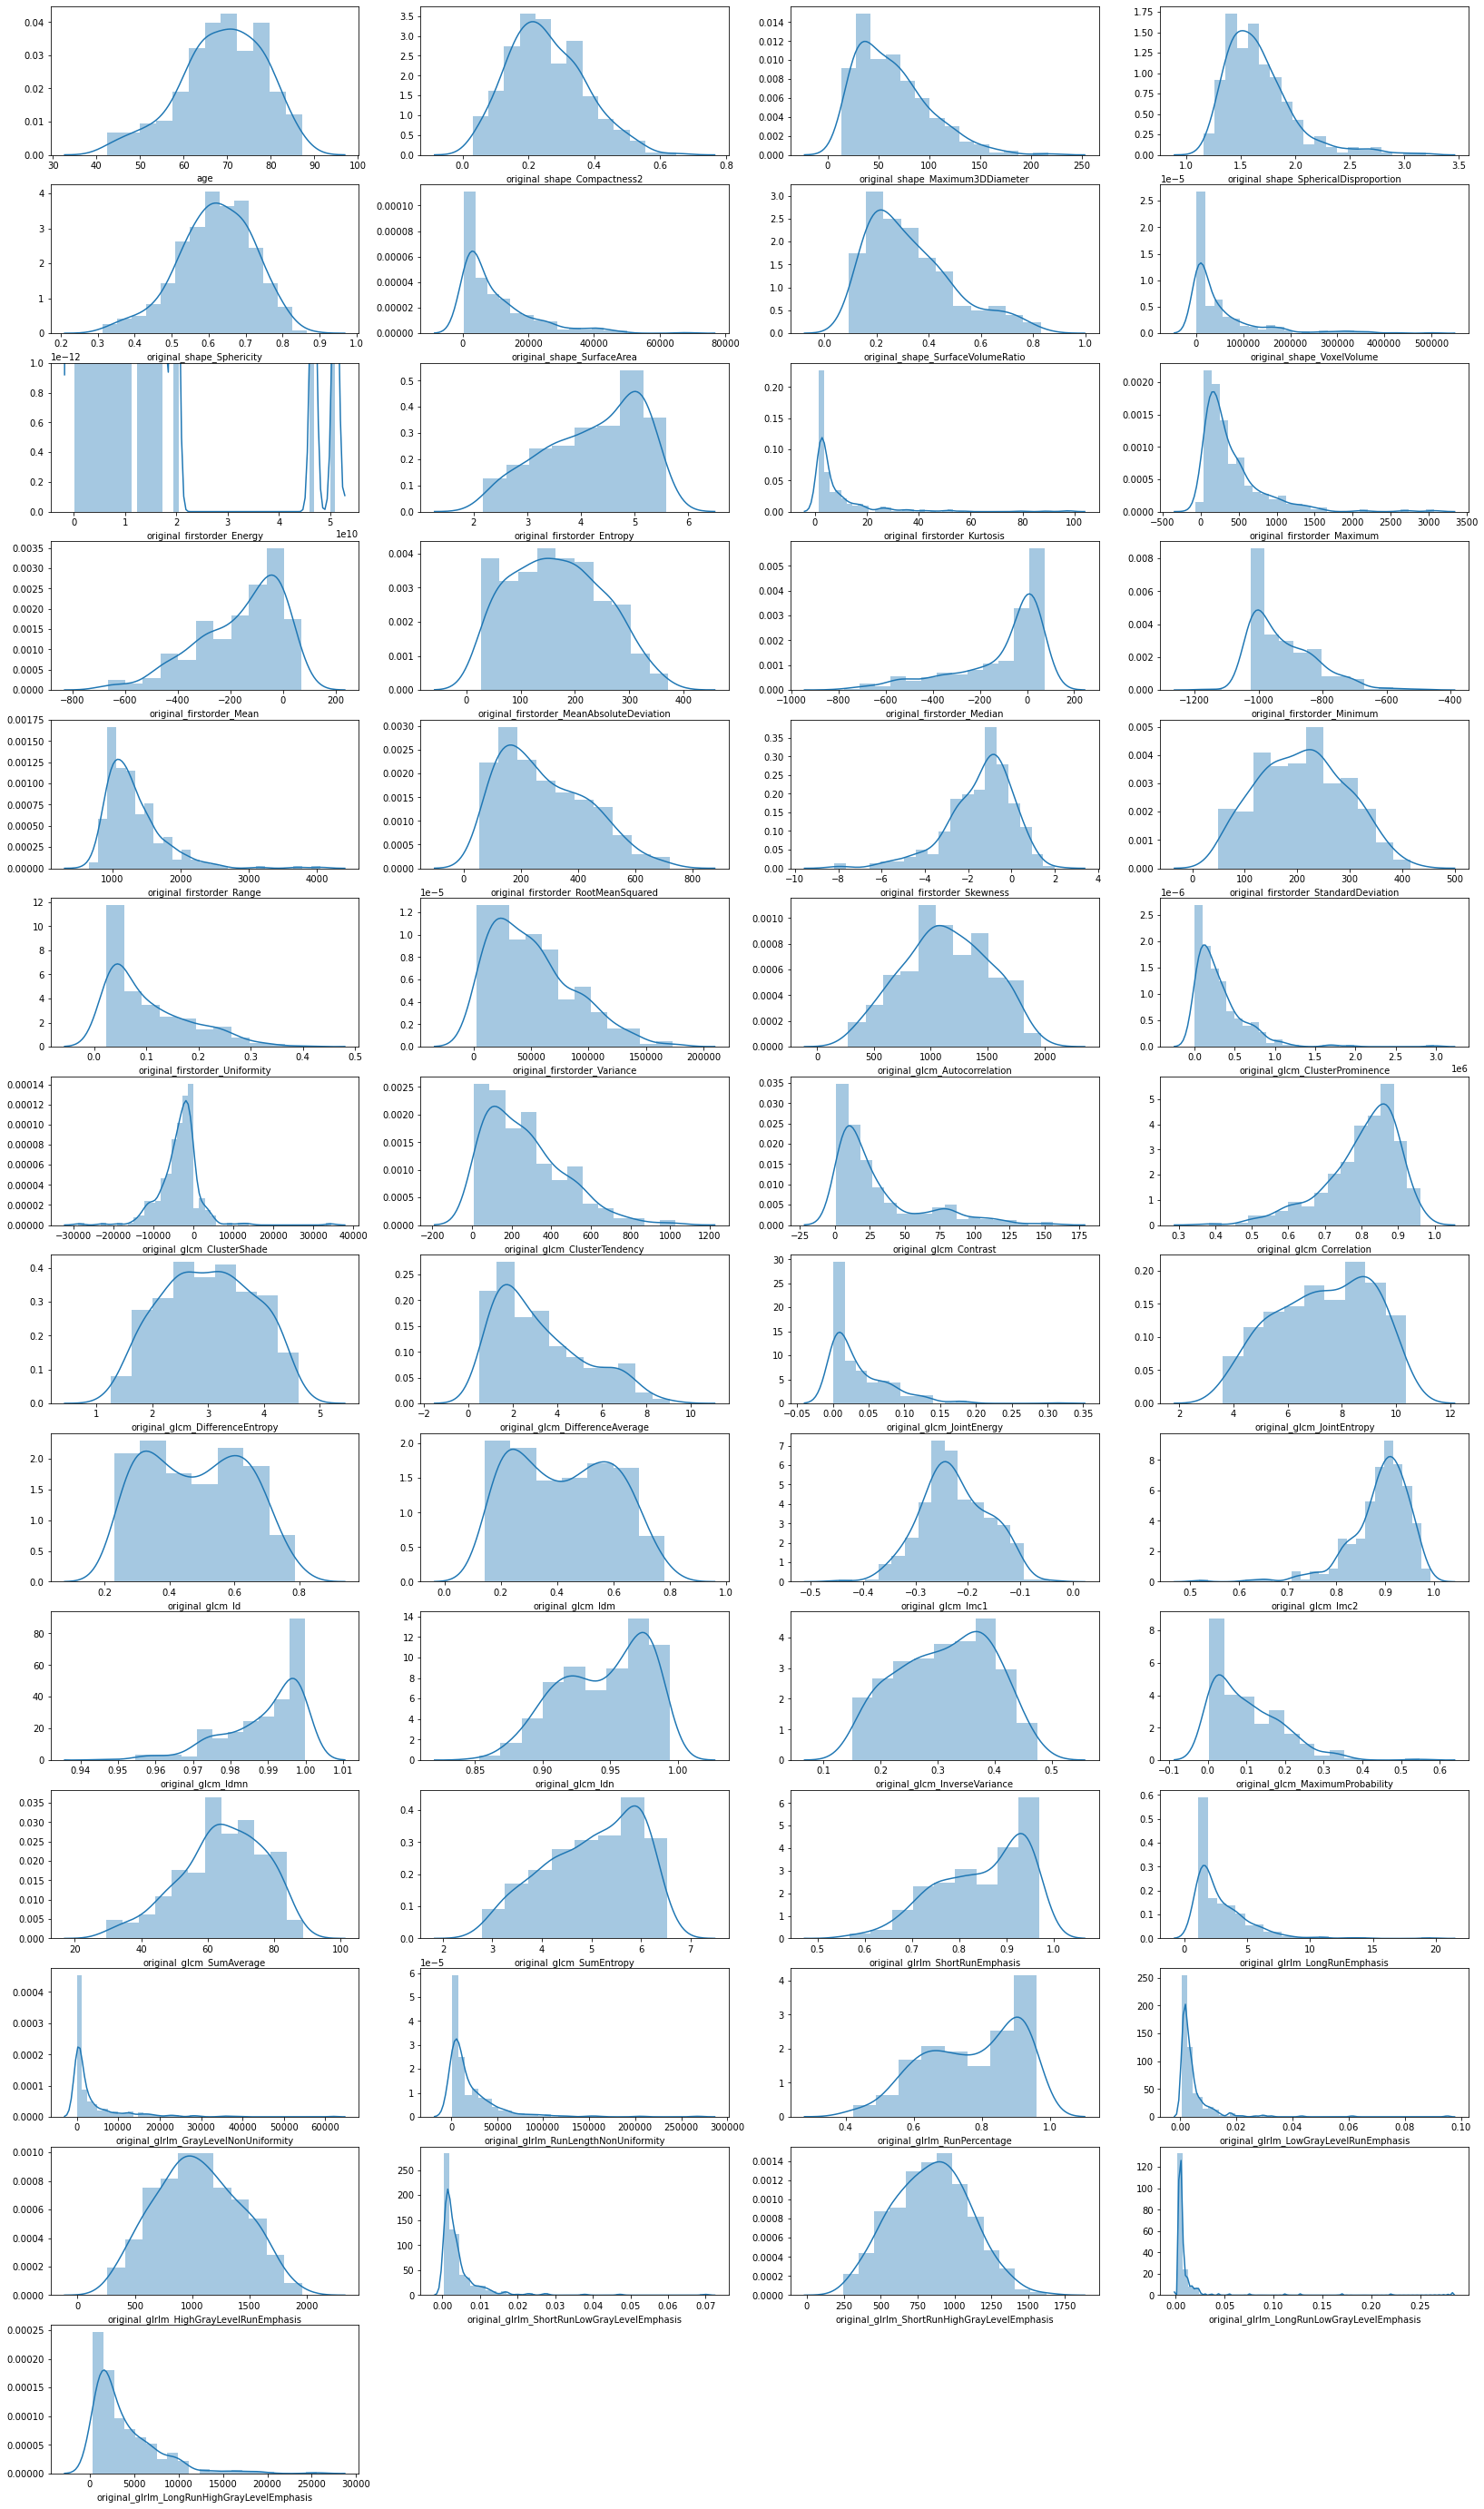

In [1653]:
j=0
plt.figure(figsize=(28,50)) #Taille du graphe

for col in train_data[['age']+list(train_data.columns)[7:]]:
    j+=1
    plt.subplot(14, 4, j)
    plt.subplot(14, 4, j)
    sns.distplot(train_data[col])

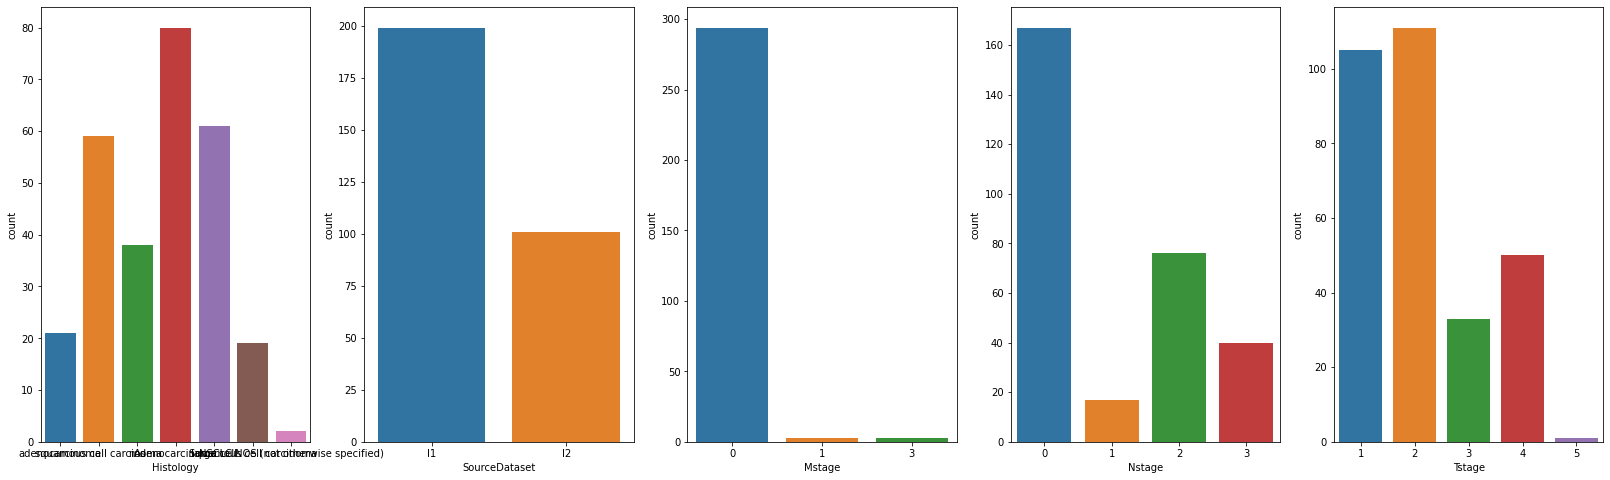

In [1654]:
i=0
fig, ax =plt.subplots(1,5)
fig.set_size_inches(28, 8) #Taille du graphe
for col in ['Histology','SourceDataset','Mstage','Nstage','Tstage']:
    sns.countplot(train_data[col], ax=ax[i])
    i+=1

fig.show()

In [4]:
#copier data
train_df=train_data.copy()
train_df.shape

(300, 59)

# preprocesing data:

#### Aprés une premier analyse exploratoire du dataset on va commencer par préparer le dataset avant de commencer la modélisation.Pour cela on crée une fonction preprocess qui prend un argument datapour le dataframe contenent les données brut et l'argugement phase pour dire à la fonction s'il s'agit de la phase d'apprantissage ou de test cette fontion elle va faire les transformationsuivante:
##### 1:il ya un seul patient avec Tstage=5 on décide de le mettre dans la catégorie 4
##### 2: si on est dans la phase test  pour les 2 patients avec Nstage="4" on le regroupe avec la categorie 3
##### 3: corriger et renommer les modalité de la variable Histologie: regrouper not spécified et nan en cat 3-encodage des variable catégoriele Tstage, Nstage and Histology_cat
##### 4: remplacer les valeur manquante de age par median
##### 5: staandariser les variable numériques (mean=0, standard deviation=1)
##### 6: rassembler le dataset prétraité avec les variable réponses.

In [5]:
def preprocess(Data,phase='training'):
    Dataset=Data.copy()
    #Dataset.dropna(axis=0,inplace=True)# décommenter pour supprimer les lignes avec valeur manquante
    #il ya un seul patient avec Tstage=5 on décide de le mettre dans la catégorie 4
    Dataset['Tstage']=Dataset.Tstage.apply(lambda x: 4 if x==5 else x)
    if phase== 'testing':
        #la méme chose pour les 2 patients avec Nstage="4" on le regroupe avec la categorie 3
        Dataset['Nstage']=Dataset.Nstage.apply(lambda x: 3 if x==4 else x)
    
    #corriger et renommer les modalité de la variable Histologie
    #regrouper not spécified et nan en cat 3
    Dataset['Histology_cat']=Dataset.Histology.apply(lambda x: 0 if x in ('Adenocarcinoma','adenocarcinoma') 
                                                               else 1 if x=='large cell' 
                                                               else 2 if x in('squamous cell carcinoma', 'Squamous cell carcinoma') 
                                                               else 3)
    
    #encodage des variable catégoriele Tstage, Nstage and Histology_cat
    # supprimer les colone Mstage faible variance et histology déga encodée
    Dataset=Dataset.drop(columns=["Mstage", "Histology"])

    categories = ["SourceDataset",'Nstage', 'Tstage', 'Histology_cat']
    Dataset = pd.get_dummies(Dataset, columns=categories, drop_first=True)

    # récupérer les variables numériques  pour les traiter avec une pipline
    x_train=Dataset.drop(columns=["SourceDataset_l2",'Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4', 'Histology_cat_1', 'Histology_cat_2','Histology_cat_3'])

    
    #categorical_features_1 = ['SourceDataset']

    categorical_transformer_1 = Pipeline(
        steps=[('encoder', OneHotEncoder(drop='first'))])


    
    numeric_features_1 = x_train.select_dtypes(include=['int64','float64']).columns

    numeric_transformer_1 = Pipeline(
        steps=[('imputer', SimpleImputer(strategy="median")),('scaler', StandardScaler())
    ])
    # remplacer les valeur manquante par median
    #staandariser les variable numériques (mean=0, standard deviation=1)

    # appliquer la pipline au colones
    preprocessor = ColumnTransformer(
        transformers=[
            ('num_1', numeric_transformer_1, numeric_features_1)
           # ('cat', categorical_transformer_1, categorical_features_1)
        ])
    
    x_train_ = preprocessor.fit_transform(x_train)
    
    x_train=pd.DataFrame(x_train_, index=x_train.index, columns=x_train.columns)
    #concatener les variable catégoriél et numérique après prétraitement
    test=Dataset.loc[:,["SourceDataset_l2",'Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4','Histology_cat_1', 'Histology_cat_2','Histology_cat_3']]

    #rasembler le dataset prétraité avec les variable réponses
    x_train=pd.merge(x_train, test, how='inner', left_index=True, right_index=True, sort=True)

    
    return x_train

    

X_train=preprocess(train_df,phase='training')
X_train.shape


    

(300, 64)

In [6]:
y_train = pd.read_csv('Y_train\\output_VSVxRFU.csv', index_col=0)
y_train=y_train.sort_index()
y_train.head()

,SurvivalTime,Event
PatientID,,
2,638,0
3,421,0
4,465,1
5,1295,1
7,1393,0


## preprocessing test data:

#### Appliquer les mémes transformationsss au données de test:

In [7]:
test_data=extractdata(phase='testing')

In [8]:
test_df=test_data.copy()
X_test=preprocess(test_df,phase='testing')
X_test

,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,SourceDataset_l2,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
PatientID,,,,,,,,,,,,,,,,,,,,,
0,1.051352,0.376051,0.268695,-0.330007,-0.505083,0.408075,-0.800812,0.671244,-0.604589,-0.321487,...,1,0,0,0,0,0,0,0,1,0
1,0.411901,-0.562246,-0.632675,0.315426,0.365959,-0.530071,0.004097,-0.519993,-0.192892,-0.157681,...,0,0,1,0,1,0,0,0,1,0
6,-0.356678,1.132847,1.146276,-0.608512,-1.015669,1.118346,-0.572462,-0.453027,-0.467343,-0.418037,...,0,0,1,0,0,0,1,0,0,1
9,-1.797572,-1.216969,-1.139212,-0.357148,1.235662,-1.233496,-0.361477,0.286894,-0.463462,1.282257,...,1,0,0,0,1,0,0,0,0,0
10,1.303879,-1.336063,-1.220534,1.008322,1.429098,-1.366793,0.774914,-0.586281,0.199923,-0.069580,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0.847857,2.457685,3.006258,-1.562158,-1.668705,2.285523,-0.952645,1.778209,-0.647557,-0.577375,...,1,0,0,0,0,0,0,0,0,0
412,0.440868,-0.482404,-0.564020,-1.019264,0.277667,-0.447318,-0.846291,1.762182,-0.627687,-0.372616,...,1,0,0,0,0,0,0,0,0,0
413,1.326436,-0.021050,-0.138003,-0.383720,-0.176485,0.019742,-0.751379,0.618197,-0.590412,-0.455647,...,0,0,0,0,0,0,1,1,0,0


In [9]:
#storing preprocessed data
X_train.to_csv('preprosseced data\\data_train_X_prerocessed.csv')
y_train.to_csv('preprosseced data\\data_train_y_prerocessed.csv')
X_test.to_csv('preprosseced data\\data_test_X_prerocessed.csv')
        

## Model1:

#### On commence par un premier modél Cox PH en utilisant la library lifelines (https://lifelines.readthedocs.io/en/latest/)en suivant les étapes suivantes:
##### 1) on supprime les variables qui ont peut d'influence sur le temps de survie en ajustant à chaque fois un modéle de cox simple avec un seuil dans notre cas on a choisis le seuil de coéfficient de regression 0.12.
##### 2) vu que les modéles de regression sont trop sensible à la multicolinéarité entre les variable explicatives on décide de surpprimer les variables trop corrélées (seuil 0.8) et on en garde qu'une seul. 
##### 3) on faite une selection backward
#### 4) notre modéle est prét pour les prédictions.
### résultat sur public leadboard :0.719

In [10]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()


In [11]:
#afficher le dataset
X_train_model=pd.merge(X_train, y_train, how='inner', left_index=True, right_index=True, sort=True)
X_train_model

,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
2,-1.009848,-0.296565,-0.407419,1.041538,0.058710,-0.252390,1.461731,-1.142877,1.556183,-0.177261,...,0,0,0,1,0,0,0,0,638,0
3,0.887612,-1.863412,-1.578664,3.224409,2.196868,-1.953443,-0.660012,2.271780,-0.627350,-0.352041,...,0,1,0,0,0,0,1,0,421,0
4,1.689864,-0.500805,-0.593384,1.977795,0.250020,-0.459038,0.830792,-0.944100,0.660061,0.647718,...,0,0,0,1,0,0,1,0,465,1
5,0.323547,0.728468,0.676625,-0.688274,-0.696534,0.735175,-0.676635,0.087146,-0.580836,-0.522083,...,0,0,1,0,0,0,0,1,1295,1
7,-0.869656,-0.178656,-0.295517,0.965627,-0.044323,-0.134732,1.462009,-1.168301,1.623881,0.211314,...,0,0,0,0,1,0,1,0,1393,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0.018269,-1.540581,-1.385384,-0.447978,1.587127,-1.577719,-0.633827,1.584749,-0.612307,-0.341631,...,1,0,0,0,0,0,0,0,528,1
421,-0.427642,0.140806,0.024384,-0.091953,-0.299831,0.178425,-0.202858,-0.598396,-0.260928,-0.316766,...,1,0,0,0,1,1,0,0,1503,0
422,-0.290981,-0.899297,-0.927487,1.334284,0.679102,-0.873546,1.359344,-0.962259,1.091481,0.847286,...,0,0,0,0,1,0,1,0,315,0


# Features Selection:

In [12]:
# analyse univarié pour récupérer les variable ayant le plus d'influence sur la variable cible
variable_selected=[]
for variable in X_train.columns:
  X_train_selection=X_train_model.loc[:,[f'{variable}','SurvivalTime','Event']]
  cph.fit(X_train_selection, duration_col='SurvivalTime', event_col='Event')
  #cph.print_summary()
  if abs(cph.params_[variable])<0.12:
        variable_selected.append(variable)
print(len(variable_selected))  
X_train_model.shape
print(variable_selected)

8
['original_shape_Compactness1', 'original_shape_Compactness2', 'original_shape_SphericalDisproportion', 'original_shape_Sphericity', 'original_firstorder_Energy', 'original_firstorder_Minimum', 'original_glcm_ClusterProminence', 'original_glrlm_LongRunLowGrayLevelEmphasis']


In [14]:
X_train_model_ = X_train_model.drop(columns=["original_shape_Compactness1", "original_shape_Compactness2", 
                                             "original_shape_SphericalDisproportion", "original_shape_Sphericity", 
                                             "original_firstorder_Energy", "original_firstorder_Minimum", 
                                             "original_glcm_ClusterProminence", "original_glrlm_LongRunLowGrayLevelEmphasis"])

cph.fit(X_train_model_, duration_col='SurvivalTime', event_col='Event')


<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>

In [15]:
X_train_model_numeric = X_train_model_.drop(columns=['SourceDataset_l2','SurvivalTime','Event','Nstage_1','Nstage_2','Nstage_3',
                                                     'Tstage_2','Tstage_3','Tstage_3','Tstage_4',
                                                     'Histology_cat_1','Histology_cat_2', 'Histology_cat_3'])
            
# calculer la matrice de corrélation
corr = X_train_model_numeric.corr()
#corr

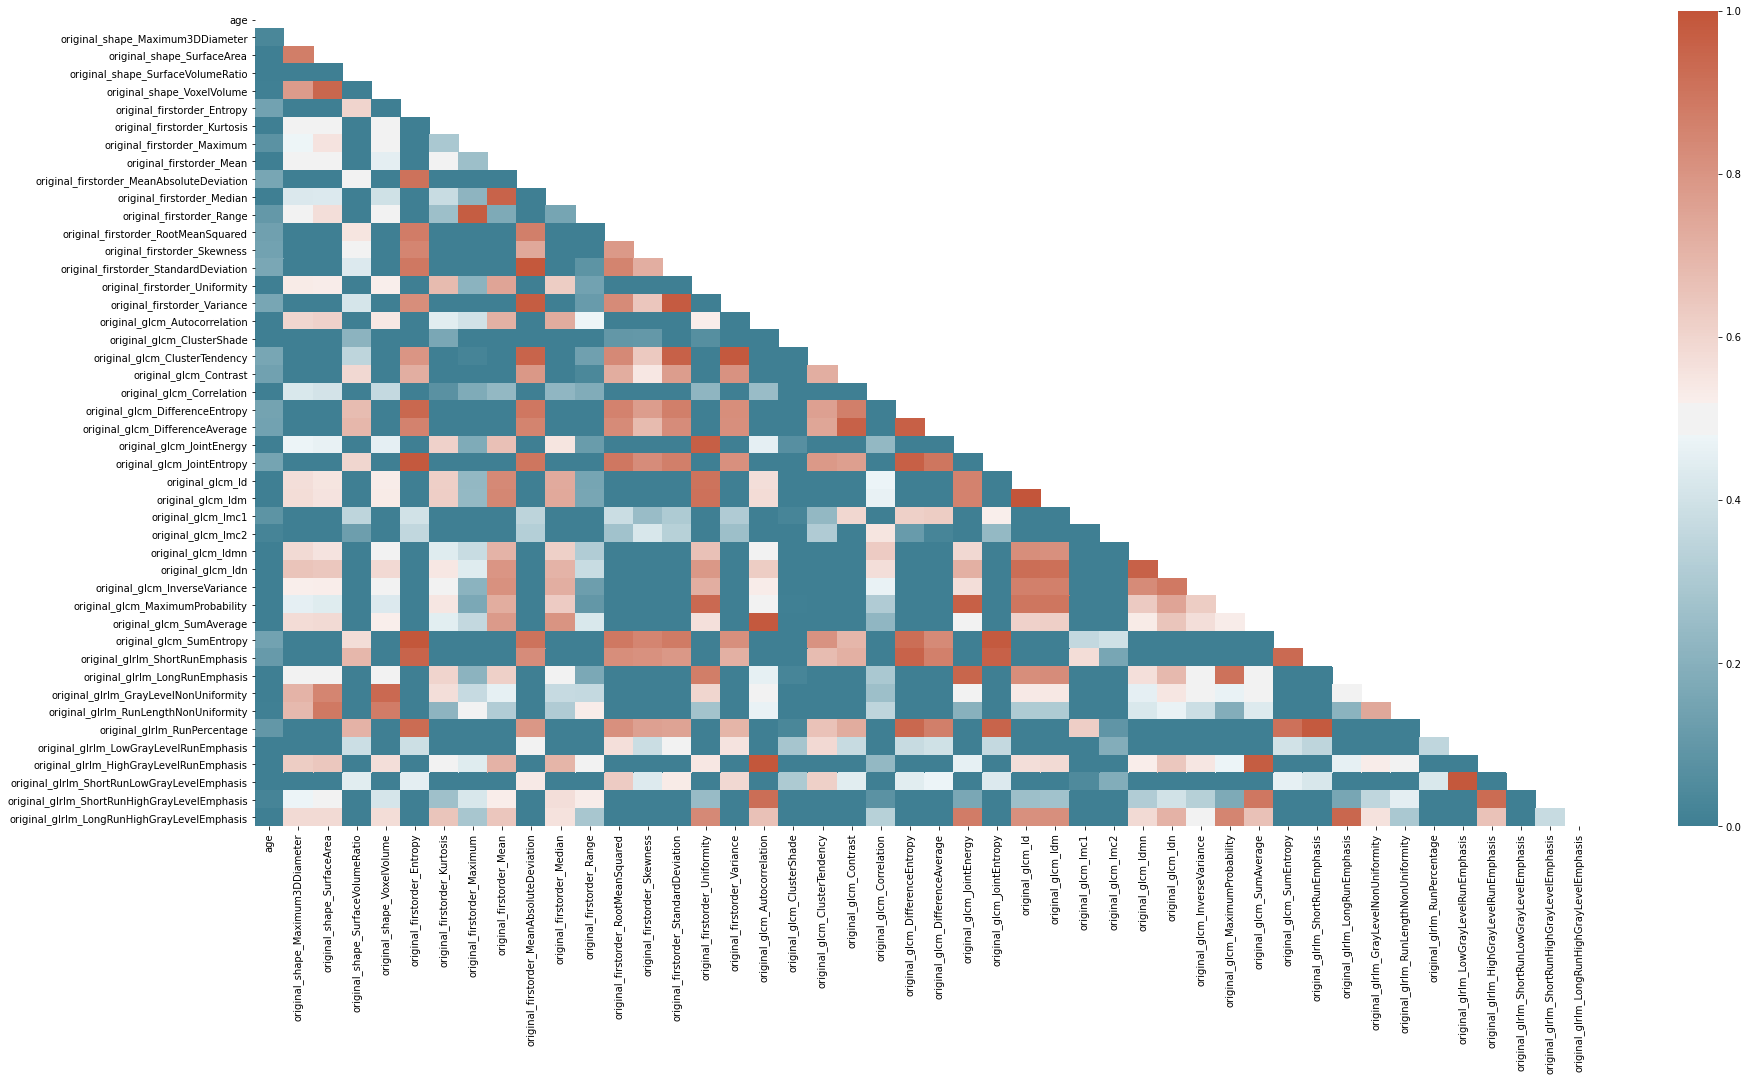

In [16]:
#visualiser la matrice de corrélation
f, ax = plt.subplots(figsize=(30, 15))

#masquer la partie triangulaire superieur
mask = np.triu(np.ones_like(corr, dtype=bool))
                

cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=0, vmax=1)

In [17]:
# Compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["variables"] = X_train_model_numeric.columns
vif["VIF"] = [variance_inflation_factor(X_train_model_numeric.values, i) for i in range(X_train_model_numeric.shape[1])]
#vif

In [18]:
#regarder les correlation 2 à 2 et supprimer les variables trop corrélées
X_train_model_2 = X_train_model_.drop(columns=["original_glcm_Id","original_glcm_Idm","original_firstorder_Range", 
                                               "original_glcm_JointEntropy", "original_glrlm_HighGrayLevelRunEmphasis",
                                               "original_firstorder_Entropy","original_firstorder_Uniformity", 
                                               "original_firstorder_Variance","original_glcm_Autocorrelation",
                                                   "original_glcm_DifferenceAverage","original_glcm_DifferenceEntropy",
                                               "original_glcm_Idn","original_firstorder_MeanAbsoluteDeviation",
                                               "original_firstorder_RootMeanSquared","original_glrlm_RunPercentage",
                                               "original_glrlm_ShortRunLowGrayLevelEmphasis","original_glcm_SumEntropy",
                                               "original_glcm_SumAverage","original_firstorder_StandardDeviation",
                                               "original_firstorder_Mean","original_glcm_JointEnergy","original_shape_VoxelVolume",
                                               "original_glrlm_ShortRunEmphasis", "original_glrlm_LongRunHighGrayLevelEmphasis",
                                               "original_shape_SurfaceArea","original_glcm_Contrast","original_glcm_Imc1",
                                               "original_glrlm_LongRunEmphasis"])

In [19]:
#selection backward: On séléctionne du modéle cox en minimisant l'aic
cph.fit(X_train_model_2, duration_col='SurvivalTime', event_col='Event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>
             duration col = 'SurvivalTime'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 300
number of events observed = 162
   partial log-likelihood = -789.70
         time fit was run = 2022-01-21 16:52:41 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
age                                            0.24       1.27       0.09             0.06             0.41                 1.06                 1.51
original_shape_Maximum3DDiameter               0.03       1.03       0.15            -0.27             0.32                 0.77                 1.37
original_shape_SurfaceVolumeRatio              0.23       1.26       0.20            -0.16             0.62                 0.85                 1.85
original_firstorder_Kurtosis                   0.07       1.07       0.13            -0.19             0.32                 0.83                 1.37
original_firstorder_Maximum                    0.06       1.06       0.13            -0.20             0.32                 0.82                 1.37
original_firstorder_Median                     0.28       1.32       0.30            -0.31             0.87                 0.73                 2.38
original_firstorder_Skewness                   0.23       1.25       0.18            -0.13             0.58                 0.88                 1.78
original_glcm_ClusterShade                    -0.02       0.98       0.15            -0.32             0.28                 0.72                 1.33
original_glcm_ClusterTendency                  0.53       1.70       0.25             0.05             1.01                 1.05                 2.74
original_glcm_Correlation                     -0.22       0.80       0.27            -0.76             0.31                 0.47                 1.37
original_glcm_Imc2                             0.03       1.03       0.19            -0.35             0.41                 0.71                 1.51
original_glcm_Idmn                             0.10       1.11       0.28            -0.45             0.65                 0.64                 1.91
original_glcm_InverseVariance                  0.31       1.36       0.24            -0.17             0.79                 0.84                 2.19
original_glcm_MaximumProbability               0.27       1.30       0.17            -0.08             0.61                 0.93                 1.84
original_glrlm_GrayLevelNonUniformity          0.20       1.22       0.17            -0.14             0.53                 0.87                 1.70
original_glrlm_RunLengthNonUniformity         -0.02       0.98       0.17            -0.35             0.31                 0.70                 1.36
original_glrlm_LowGrayLevelRunEmphasis        -0.03       0.97       0.13            -0.29             0.23                 0.75                 1.26
original_glrlm_ShortRunHighGrayLevelEmphasis   0.04       1.04       0.14            -0.24             0.33                 0.79                 1.39
SourceDataset_l2                              -1.33       0.27       0.43            -2.17            -0.48                 0.11                 0.62
Nstage_1                                       0.23       1.25       0.36            -0.48             0.93                 0.62                 2.53
Nstage_2                                       0.60       1.83       0.22             0.18             1.03                 1.19                 2.80
Nstage_3                                       0.48       1.61       0.27            -0.06             1.01                 0.94                 2.76
Tstage_2                           

In [23]:
#final model
X_train_model_final = X_train_model_2.drop(columns=["original_glcm_ClusterShade","original_glrlm_RunLengthNonUniformity",
                                                    "original_shape_Maximum3DDiameter","original_glcm_Imc2",
                                                    "original_glrlm_LowGrayLevelRunEmphasis",
                                                    "original_glrlm_ShortRunHighGrayLevelEmphasis","original_glcm_Idmn",
                                                    "original_firstorder_Kurtosis","Tstage_2","Tstage_3","Tstage_4",
                                                    "original_glcm_Correlation","original_firstorder_Skewness", 
                                                    "original_glcm_InverseVariance","original_shape_SurfaceVolumeRatio",
                                                    "original_glcm_MaximumProbability","Histology_cat_1","Histology_cat_2",
                                                    "Histology_cat_3","original_firstorder_Maximum"])

cph.fit(X_train_model_final, duration_col='SurvivalTime', event_col='Event')
#cph.print_summary()

<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>

In [24]:
#prediction
#Only variables selected in the final model are kept to make the predictions on the expected lifetime
X_test_model = X_test[["original_firstorder_Median","original_glcm_ClusterTendency","original_glrlm_GrayLevelNonUniformity","age",
                       "SourceDataset_l2", "Nstage_1","Nstage_2","Nstage_3"
                    ]]

prediction_test_cph=cph.predict_expectation(X_test_model)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>
             duration col = 'SurvivalTime'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 300
number of events observed = 162
   partial log-likelihood = -795.94
         time fit was run = 2022-01-21 16:53:01 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
age                                     0.22       1.25       0.08             0.06             0.39                 1.06                 1.48
original_firstorder_Median              0.41       1.51       0.14             0.15             0.68                 1.16                 1.98
original_glcm_ClusterTendency           0.31       1.36       0.11             0.09             0.53                 1.10                 1.70
original_glrlm_GrayLevelNonUniformity   0.22       1.24       0.08             0.06             0.37                 1.06                 1.45
SourceDataset_l2                       -1.08       0.34       0.23            -1.54            -0.63                 0.21                 0.53
Nstage_1                                0.18       1.19       0.35            -0.51             0.86                 0.60                 2.37
Nstage_2                                0.48       1.62       0.20             0.10             0.87                 1.11                 2.38
Nstage_3                                0.42       1.52       0.25            -0.07             0.91                 0.93                 2.48

                                          z      p   -log2(p)
covariate                                                    
age                                    2.67   0.01       7.03
original_firstorder_Median             3.02 <0.005       8.65
original_glcm_ClusterTendency          2.78   0.01       7.52
original_glrlm_GrayLevelNonUniformity  2.73   0.01       7.32
SourceDataset_l2                      -4.68 <0.005      18.42
Nstage_1                               0.50   0.62       0.70
Nstage_2                               2.47   0.01       6.21
Nstage_3                               1.68   0.09       3.42
---
Concordance = 0.71
Partial AIC = 1607.88
log-likelihood ratio test = 86.00 on 8 df
-log2(p) of ll-ratio test = 48.24

In [25]:
            output=pd.DataFrame(data=prediction_test_cph,index=X_test_model.index)
            output=output.rename(columns={0:'SurvivalTime'})
            output.describe()
            output['Event']=np.nan
            output.to_csv('SubmissionFolder\\submission_Cox_best.csv')
            output
#0.7233738384508694
#Concordance	0.72
#Partial AIC	1206.56
#SubmissionFolder\\submission_Cox_bestfinal.csv

,SurvivalTime,Event
PatientID,,
0,2516.748007,NaN
1,619.196720,NaN
6,761.154826,NaN
9,3198.933734,NaN
10,477.604215,NaN
...,...,...
411,2188.071282,NaN
412,3047.360813,NaN
413,1127.208865,NaN


# 2 CoxPH avec une ACP:

### dans cette partie on utiliser un acp pour produire de nouvelles variables indépendante et on choisit les varible ayant la plus grande influence sur la variable cible:
#### 1) on prend les 30 premier composantes principales 
#### 2) on choisis les variables avec le meilleur pouvoir prédictif
#### 3)on fait une regression cox sur ces variables
## Resultat sur public leadboard de 0.7205

In [26]:
#cox Ph sur les composantess
from sklearn.decomposition import PCA
pca=PCA(30)#=6
X_train_pca=X_train.drop(columns=["SourceDataset_l2",'Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4', 'Histology_cat_1', 'Histology_cat_2','Histology_cat_3'])

pca.fit_transform(X_train_pca).shape
X_train_pca=pd.DataFrame( pca.fit_transform(X_train_pca) ,index=X_train_pca.index)
#X_train_model_pca=pd.merge(X_train_pca, X_train[["SourceDataset_l2",'Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4', 'Histology_cat_1', 'Histology_cat_2','Histology_cat_3']], how='inner', left_index=True, right_index=True, sort=True)
X_train_model_pca=pd.merge(X_train_pca, y_train, how='inner', left_index=True, right_index=True, sort=True)
X_train_model_pca=pd.merge(X_train_model_pca, X_train[["SourceDataset_l2", "Nstage_1","Nstage_2","Nstage_3"]], how='inner', left_index=True, right_index=True, sort=True)
X_train_model_pca

############# pca test
#X_test

from sklearn.decomposition import PCA
X_test_pca=X_test.drop(columns=["SourceDataset_l2",'Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4', 'Histology_cat_1', 'Histology_cat_2','Histology_cat_3'])

#pca.fit_transform(X_test_pca).shape
X_test_model_pca=pd.DataFrame( pca.fit_transform(X_test_pca) ,index=X_test_pca.index)
#X_train_model_pca=pd.merge(X_train_pca, X_train[["SourceDataset_l2",'Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4', 'Histology_cat_1', 'Histology_cat_2','Histology_cat_3']], how='inner', left_index=True, right_index=True, sort=True)
#X_test_model_pca=pd.merge(X_test_pca, y_test, how='inner', left_index=True, right_index=True, sort=True)
X_test_model_pca=pd.merge(X_test_model_pca, X_test[["SourceDataset_l2", "Nstage_1","Nstage_2","Nstage_3"]], how='inner', left_index=True, right_index=True, sort=True)
X_test_model_pca

X_train_model_pca

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,SurvivalTime,Event,SourceDataset_l2,Nstage_1,Nstage_2,Nstage_3
PatientID,,,,,,,,,,,,,,,,,,,,,
2,7.345975,0.192618,-0.184808,1.192731,-0.125763,1.539485,0.725377,0.036775,-0.623633,0.082101,...,0.017947,-0.048302,-0.063838,0.048796,638,0,0,0,0,0
3,-4.919805,1.965313,-1.752186,3.145899,-2.302965,-1.516638,-0.765216,-1.405239,-0.354367,-0.580956,...,0.108759,0.055802,-0.079266,0.065695,421,0,0,0,0,1
4,2.048366,2.691242,0.730622,-1.844492,-2.231916,-0.477138,-0.204708,1.364515,0.820882,0.265143,...,0.125266,-0.133627,0.066599,0.125119,465,1,0,0,0,0
5,8.476971,-4.135343,0.101596,1.431060,3.388634,-0.893360,-1.101718,-0.239928,0.722194,-0.599309,...,0.429145,0.105976,0.034545,-0.000950,1295,1,0,0,0,0
7,6.451262,0.817595,1.163224,0.072938,-0.898162,1.100734,0.022180,0.333042,-0.594644,0.629438,...,-0.014346,-0.028088,-0.014594,0.088388,1393,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-5.582117,2.693427,-2.632131,1.242087,0.013306,-1.443056,-0.407611,-0.270664,-0.203514,0.369811,...,0.116345,0.016023,0.018665,0.018936,528,1,1,0,1,0
421,3.034159,-0.604866,0.205638,-1.613378,-0.065769,-1.666664,-0.034840,0.235920,-0.742375,-0.195127,...,-0.001364,0.048459,-0.052355,-0.027597,1503,0,0,0,1,0
422,4.485005,2.775673,0.635865,-0.484355,-0.048908,-0.812096,-0.684752,-1.287065,-0.265246,0.270926,...,-0.031275,0.006749,0.087832,-0.034862,315,0,0,0,0,0


In [1623]:
from lifelines import CoxPHFitter
cph_PCA = CoxPHFitter()
cph_PCA.fit(X_train_model_pca, duration_col='SurvivalTime', event_col='Event')

<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>

In [1637]:
# Univariate analysis
variable_selected=[]
for variable in X_train_model_pca.drop(['SurvivalTime','Event'],axis=1).columns:
  X_train_selection=X_train_model_pca[[variable,'SurvivalTime','Event']]
  cph.fit(X_train_selection, duration_col='SurvivalTime', event_col='Event')
  #cph.print_summary()
  if abs(cph.params_[variable])>0.03:#0.02==>0.712  0.005==>0.7205 pca30
        variable_selected.append(variable)
print(len(variable_selected))  
X_train_model_pca.shape
print(variable_selected)

34
[0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 'SourceDataset_l2', 'Nstage_1', 'Nstage_2', 'Nstage_3']


In [1638]:
X_train_model_pca_final=X_train_model_pca[variable_selected+['SurvivalTime','Event']]
X_test_model_pca_final=X_test_model_pca[variable_selected]

In [1639]:
cph_PCA = CoxPHFitter()
cph_PCA.fit(X_train_model_pca_final, duration_col='SurvivalTime', event_col='Event')

<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>

In [1640]:
prediction_test_cph_PCA=cph_PCA.predict_expectation(X_test_model_pca_final)
output=pd.DataFrame(data=prediction_test_cph_PCA,index=X_test_model_pca_final.index)
output=output.rename(columns={0:'SurvivalTime'})
output.describe()
output['Event']=np.nan
output.to_csv('SubmissionFolder\\submission_Cox_best_PCA_all+covariance selection.csv')
output#4:0.69-6-0.71
cph_PCA.print_summary()

<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>
             duration col = 'SurvivalTime'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 300
number of events observed = 162
   partial log-likelihood = -784.90
         time fit was run = 2022-01-19 20:39:10 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
0                  0.06       1.06       0.03             0.01             0.11                 1.01                 1.12
1                  0.08       1.08       0.03             0.01             0.14                 1.01                 1.15
2                  0.07       1.08       0.05            -0.03             0.18                 0.97                 1.20
3                 -0.05       0.95       0.05            -0.16             0.06                 0.86                 1.06
5                  0.03       1.03       0.07            -0.10             0.16                 0.90                 1.17
7                 -0.02       0.98       0.07            -0.15             0.12                 0.86                 1.13
8                  0.24       1.27       0.09             0.07             0.40                 1.07                 1.50
10                 0.22       1.24       0.11             0.01             0.42                 1.01                 1.52
11                 0.09       1.09       0.12            -0.15             0.32                 0.86                 1.38
12                -0.20       0.82       0.12            -0.45             0.04                 0.64                 1.04
13                 0.08       1.08       0.16            -0.24             0.39                 0.79                 1.48
15                 0.13       1.14       0.20            -0.26             0.51                 0.77                 1.67
17                 0.29       1.33       0.22            -0.14             0.71                 0.87                 2.03
18                 0.30       1.35       0.24            -0.16             0.77                 0.85                 2.15
19                -0.49       0.61       0.29            -1.06             0.08                 0.34                 1.08
20                 0.57       1.77       0.29            -0.00             1.14                 1.00                 3.13
21                -0.22       0.80       0.36            -0.93             0.49                 0.39                 1.63
22                -0.18       0.83       0.35            -0.86             0.50                 0.42                 1.65
23                -0.45       0.64       0.39            -1.22             0.32                 0.29                 1.37
24                 0.14       1.15       0.41            -0.66             0.95                 0.52                 2.58
25                 0.09       1.09       0.50            -0.88             1.06                 0.41                 2.89
26                -0.11       0.89       0.50            -1.09             0.86                 0.34                 2.37
27                -0.38       0.69       0.59            -1.53             0.77                 0.22                 2.17
28                 0.04       1.04       0.57            -1.08             1.15                 0.34                 3.16
30                -0.24       0.79       0.75            -1.71             1.24                 0.18                 3.46
31                -0.30       0.74       0.85            -1.96             1.36                 0.14                 3.91
32                -1.53       0.22       0.95            -3.38             0.32                 0.03                 1.38
33                -0.84       0.43       1.08            -2.97             1.28                 0

### Cette méthode donne notre meiileur résultat sur le publicleadboard du challenge avec 0.7205

# Model2 Survival Random Forest:

#### Dans cette partie on utilise l'algorithme Random survivalForest regarder de la librarie python sickit survival(https://scikit-survival.readthedocs.io/en/stable/)

In [20]:
from sksurv.ensemble import RandomSurvivalForest
model_rf = RandomSurvivalForest()
model_rf

RandomSurvivalForest()

In [21]:
#splitting data to train and validation set
rs = 20

va_x=X_train.copy()
va_y=y_train[['Event','SurvivalTime']].copy()
va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
    va_x, va_y, test_size=0.2, stratify=va_y["Event"], random_state=rs
)

# Saving feature names for later use
X_list = list(va_x.columns)


print(va_x_train.shape)
print(va_y_train.shape)
print(va_x_test.shape)
print(va_y_test.shape)
va_y_train

(240, 64)
(240, 2)
(60, 64)
(60, 2)


,Event,SurvivalTime
PatientID,,
57,1,1213
388,0,1962
40,0,487
347,1,50
124,1,79
...,...,...
122,1,1238
297,0,3078
348,1,706


In [41]:
#formating inputs: train
va_x_train_formated,va_y_train_formated=get_x_y(pd.concat([va_x_train,va_y_train],axis=1), attr_labels=['Event','SurvivalTime'], pos_label=True, survival=True)

va_x_test= va_x_test.sort_index()
va_y_test= va_y_test.sort_index()
#formating inputs: test
va_x_test_formated,va_y_test_formated=get_x_y(pd.concat([va_x_test,va_y_test],axis=1), attr_labels=['Event','SurvivalTime'], pos_label=True, survival=True)




In [35]:
rsf = RandomSurvivalForest(n_estimators=30, #default 100
                           min_samples_split=10, #default 6
                           min_samples_leaf=15, #default 3
                           #max_features="None", #auto , sqrt, log2
                           n_jobs=-1,
                           random_state=8)
rsf.fit(va_x_train_formated,va_y_train_formated)

# CI (concordance index) score
print(rsf.score(va_x_train_formated, va_y_train_formated))
print(rsf.score(va_x_test_formated, va_y_test_formated))

0.7578832731052918
0.7641434262948207


### on peut regarder les variables les plus fortes en terme de prédiction:

In [24]:
# feature importance
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=8)
perm.fit(va_x_test_formated, va_y_test_formated)
eli5.show_weights(perm, feature_names=X_list)

Weight,Feature
0.0150 ± 0.0124,original_glcm_ClusterProminence
0.0097 ± 0.0116,original_glcm_Id
0.0082 ± 0.0103,original_glrlm_ShortRunHighGrayLevelEmphasis
0.0075 ± 0.0107,original_glrlm_HighGrayLevelRunEmphasis
0.0070 ± 0.0131,original_glcm_Idm
0.0065 ± 0.0081,original_glcm_SumAverage
0.0065 ± 0.0113,original_glrlm_GrayLevelNonUniformity
0.0062 ± 0.0118,original_glcm_Imc1
0.0057 ± 0.0160,original_glrlm_ShortRunEmphasis
0.0052 ± 0.0085,original_glcm_MaximumProbability


#### regardant comment change la métrique en fonction de l'hyperparamétres n_estimator:

In [27]:
# evaluating role of n_estimators on c-index
scores_rsf_CI = {}

rsf_CI = RandomSurvivalForest(n_jobs=-1,
                              min_samples_split=10,
                              min_samples_leaf=15,
                           random_state=8)
for i in range(1,25):
    n_estimators = i * 5
    rsf_CI.set_params(n_estimators=n_estimators)
    rsf_CI.fit(va_x_train_formated, va_y_train_formated)
    scores_rsf_CI[n_estimators] = rsf_CI.score(va_x_test_formated, va_y_test_formated)

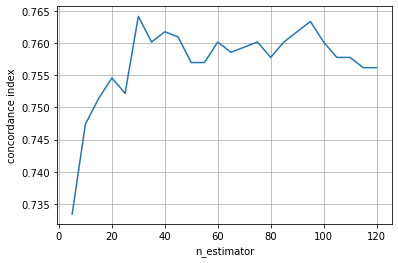

In [28]:
# plotting the effect of n_estimators on c-index
x, y = zip(*scores_rsf_CI.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

### regardant les prédiction des fonction de survie de quelque individus:

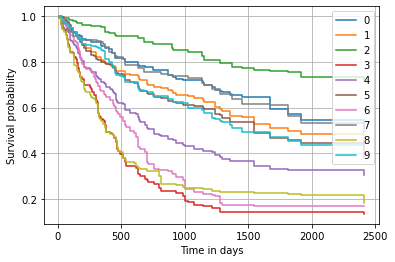

In [29]:
surv = rsf.predict_survival_function(va_x_test_formated, return_array=True)

for i, s in enumerate(surv):
    if i in np.arange(0,10):
        plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

## SurvivalRandomForest grid search:

#### Maintenant on fait une validation croisée sur tout le trainset et on choisis les meilleur hyperparamétres:

In [36]:
rsf2 = RandomSurvivalForest(n_jobs=-1,
                           random_state=8)

In [56]:
from metrics_Owkin import cindex
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    prediction=pd.DataFrame({'SurvivalTime':prediction,'Event':np.nan},index=X.index)
    ascending_risk_pred=prediction.sort_values(by=['SurvivalTime'])
    descending_risk_pred=prediction.sort_values(by=['SurvivalTime'],ascending=False)
    #switching risks:
    descending_risk_pred.index=ascending_risk_pred.index
    last_risk_pred=descending_risk_pred.copy()
    last_risk_pred=last_risk_pred.sort_index()
    #result = concordance_index_censored(y['Event'], y['SurvivalTime'], prediction)
    result=cindex(va_y_test,last_risk_pred)
    return result

def make_prediction(model, X):
    prediction = model.predict(X)
    prediction=pd.DataFrame({'SurvivalTime':prediction,'Event':np.nan},index=X.index)
    ascending_risk_pred=prediction.sort_values(by=['SurvivalTime'])
    descending_risk_pred=prediction.sort_values(by=['SurvivalTime'],ascending=False)
    #switching risks:
    descending_risk_pred.index=ascending_risk_pred.index
    last_risk_pred=descending_risk_pred.copy()
    last_risk_pred=last_risk_pred.sort_index()
    #result = concordance_index_censored(y['Event'], y['SurvivalTime'], prediction)
    #result=cindex(va_y_test,last_risk_pred)
    return last_risk_pred

In [39]:
param_grid = {'n_estimators': [50,55,100], 
              'max_depth':[10],
              'max_features': [ "auto",'sqrt','log2'],
              'min_samples_leaf': [16,17],
              'min_samples_split':[2,3]
              }
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=80)
gcv = GridSearchCV(rsf2, param_grid,
                   n_jobs=-1, refit=False,
                   cv=cv)

In [45]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
va_x_formated,va_y_formated=get_x_y(pd.concat([va_x,va_y],axis=1), attr_labels=['Event','SurvivalTime'], pos_label=True, survival=True)
gcv = gcv.fit(va_x, va_y_formated)


In [46]:
round(gcv.best_score_, 5), gcv.best_params_

(0.65681,
 {'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 16,
  'min_samples_split': 2,
  'n_estimators': 50})

In [307]:
results_df = pd.DataFrame(gcv.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_log2_16_3_50,"{'max_depth': 10, 'max_features': 'log2', 'min...",1,0.656809,0.041585
10_log2_16_2_50,"{'max_depth': 10, 'max_features': 'log2', 'min...",1,0.656809,0.041585
10_log2_16_3_55,"{'max_depth': 10, 'max_features': 'log2', 'min...",3,0.655508,0.041441
10_log2_16_2_55,"{'max_depth': 10, 'max_features': 'log2', 'min...",3,0.655508,0.041441
10_sqrt_16_3_55,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",5,0.654800,0.043572
10_auto_16_2_55,"{'max_depth': 10, 'max_features': 'auto', 'min...",5,0.654800,0.043572
10_auto_16_3_55,"{'max_depth': 10, 'max_features': 'auto', 'min...",5,0.654800,0.043572
10_sqrt_16_2_55,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",5,0.654800,0.043572
10_auto_17_2_55,"{'max_depth': 10, 'max_features': 'auto', 'min...",9,0.654119,0.044172


In [ ]:
#Faire des prédiction:
pred=make_prediction()

### le meiileur résultat obtenu à un c_index en cross validation de 0.65

In [51]:
rsf=RandomSurvivalForest(max_depth= 10,
  max_features= 'log2',
  min_samples_leaf= 16,
  min_samples_split= 2,
  n_estimators= 50)

In [52]:
rsf.fit(va_x,va_y_formated)

RandomSurvivalForest(max_depth=10, max_features='log2', min_samples_leaf=16,
                     min_samples_split=2, n_estimators=50)

In [57]:
rsf.score(va_x,va_y_formated)

0.7688365913835642

### Soumettre le resultat de Random Survival Forest :il faut noter que la fonction predict de sksurv ne donne pas des estimation des jours de survie elle donne des score de survie mais vu notre but et de maximimiser le c_index on va permuter les score et on dépose le fichier csv car cette prend en considération juste l'ordre de duré de survie et pas la valeur elle méme

output=make_prediction(rsf,X_test)
output.to_csv('SubmissionFolder\\submission_RSF.csv')

### Conclusion et perspéctives: 
#### notre meilleur résultat et le modéle CoxPH+ACP. et Random forest nous a pas donnée de bon performances. 
#### Dans ces 3 modéles on a pas utilisé des données mask et scan vu que dans l'énoncé du chalenge on dit qu'on en a déja tirer plusieurs variables donc on peut envisager d'essayer d'extraire plus d'information de ces donné images